In [1]:
import jax
import jax_metrics as jm
import jax.numpy as jnp
from jax import grad, jit, vmap
from functools import partial
from jax import random
import os
import numpy as np
import matplotlib.pyplot as plt
# Switch off the cache 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

In [24]:
class Logistic_Regression():
    """
    Basic Model + Quasi Newton Methods
    """
    def __init__(self, regularization='l2', method_opt='classic_model'):
        self.regularization = regularization
        self.method_opt = method_opt
        self.error_gradient = 0.001
        self.key = random.PRNGKey(0)
        # You need to add some variables
        self.W = None

    @staticmethod #cannot have cls or self parameter, cannot access the class attributes. Called usint class.Method()
    @jit
    def logistic_exp(W:jnp, X:jnp)->jnp:
        """
        Generate all the w^T@x values 
        args:
            W is a k-1 x d + 1
            X is a d x N
            N is the number of samples
            este término exp(wx) lo necesitamos porque aparece en la ecuación para la probabilidad
        """
        return jnp.exp(W@X)

    @staticmethod
    @jit
    def logistic_sum(exTerms: jnp)->jnp:        
        """
        Generate all the w^T@x values 
        args:
            W is a k-1 x d 
            X is a d x N
        """
        temp = jnp.sum(exTerms, axis=0) #sumatoria(exp(xw)) #aquí entra el return de logistic_exp()
        n = temp.shape[0]
        return jnp.reshape(1.0+temp, newshape=(1, n)) #esto es lo que va a ir en el denominador de las P(w|X)

    @staticmethod
    @jit
    def logit_matrix(Terms: jnp, sum_terms: jnp)->jnp:
        """
        Generate matrix
        """
        divisor = 1/sum_terms #aquí entra el return de logistic_sum
        # CADA RENGLÓN DE terms es un vector del tamaño de la dimensión d de la matriz X
        n, _ = Terms.shape  #Terms va a ser exp(wx), que es el returtn de logistic_exp() 
        
        replicate = jnp.repeat(divisor, repeats=n, axis=0 ) #repeats elements of an array
        logits = Terms*replicate  #P(w_i|x)=exp(w_ix)/(1+sum(exp(w_lx)))

        #ESTA ES LA MATRIZ DE PROBABILIDADES
        #esto  tiene shape (clases, samples)
        return jnp.vstack([logits, divisor]) #hacemos eso porque la probabilidad de la  clase K es solamente el divisor. 
    
    @partial(jit, static_argnums=(0,))
    def model(self, W:jnp, X:jnp, Y_hot:jnp,lbda=0)->jnp:
        """
        Logistic Model
        """
        W = jnp.reshape(W, self.sh)
        terms = self.logistic_exp(W, X)
        sum_terms = self.logistic_sum(terms)
        matrix = self.logit_matrix(terms, sum_terms) #matrix tiene shape (clases, samples)
        w_tr=jnp.trace(jnp.transpose(W)@W)
        return -jnp.sum(jnp.sum(jnp.log(matrix)*Y_hot, axis=0), axis=0)+lbda*w_tr #SUMA total del iesimo valor de y multiplicando a log(matriz_probabilidades)

    
    
    @staticmethod
    def one_hot(Y: jnp):
        """
        One_hot matrix
        """
        numclasses = len(jnp.unique(Y))
        return jnp.transpose(jax.nn.one_hot(Y, num_classes=numclasses)) 
    
    def generate_w(self, k_classes:int, dim:int)->jnp:
        """
        Use the random generator at Jax to generate a random generator to instanciate
        the augmented values
        """
        key = random.PRNGKey(0)
        keys = random.split(key, 1)
        w=jnp.array(random.normal(keys[0], (k_classes, dim)))
        w=(w-jnp.min(w))/(jnp.max(w)-jnp.min(w))
        return w #DE k-1+d+1
    

    @staticmethod
    def augment_x(X: jnp)->jnp:
        """
        Augmenting samples of a dim x N matrix
        """
        N = X.shape[1]
        return jnp.vstack([X, jnp.ones((1, N))])
     
   
    def fit(self, X: jnp, Y:jnp,alpha,lbda=0)->None:
        """
        The fit process
        """
        nclasses = len(jnp.unique(Y))
        X = self.augment_x(X)
        dim = X.shape[0]
        W = self.generate_w(nclasses-1, dim)
        Y_hot = self.one_hot(Y)
        self.W = getattr(self, self.method_opt, lambda W, X, Y_hot: self.error() )(W, X, Y_hot)
    
    @staticmethod
    def error()->None:
        """
        Only Print Error
        """
        raise Exception("Opt Method does not exist")
    
    
    def BFGS(self,W_old:jnp,X:jnp,Y_hot:jnp,ep=0.01)-> jnp:
        #W_old=1e-5*W_old
        n, m = W_old.shape 
        self.sh = (n, m)
        Lgrad=jax.grad(self.model,argnums=0)(jnp.ravel(W_old), X, Y_hot)
        #print('la dimension de lgrad es',Lgrad.shape)
        
        #alpha_search=jnp.array([1e-9,5e-9,1e-8,5e-8,1e-7,5e-7,100,1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,1.5,5,10])
        
        alpha_search=np.zeros(10)
        for i in range (10):
            alpha_search[i] = 1e-4 + 5e-5*i
        
        
        siz=alpha_search.shape[0]
        B_inv_old= jnp.linalg.inv(jax.hessian(self.model, argnums=0)(jnp.ravel(W_old), X, Y_hot))
        print('antes de entrar, el w es:W',W_old)
        #print('la dimension de B_inv_old',B_inv_old.shape)
        n=int(B_inv_old.shape[0])
        Id=jnp.identity(n)
        #B_inv_old=Id
        contador=0
        loss=self.model(jnp.ravel(W_old),X,Y_hot)
        print('el error 0 es',loss)
        
        while jnp.linalg.norm(Lgrad)>ep:
            print('vamos en el paso',contador)
            loss=self.model(jnp.ravel(W_old),X,Y_hot)
            print('el error es',loss)
            p=-B_inv_old@Lgrad
            
            #p=p/(jnp.linalg.norm(p))
            pt=jnp.transpose(p)
            print('el vector p es',p)
            print('este es 0')
            #vamos a ver cuáles alfas satisfacen las condiciones de Wolfe
            
            c1=1e-4
            c2=0.9
            alpha_wolfe=[]
            
            for i in range(siz):
                alpha=alpha_search[i]
                
                #W_old=jnp.reshape(W_old, self.sh) 
                Wi=W_old+alpha*jnp.reshape(p,self.sh)
                Lalfa=self.model(jnp.ravel(Wi),X,Y_hot)
                Lo=self.model(jnp.ravel(W_old),X,Y_hot)              
                lgrad=jax.grad(self.model,argnums=0)(jnp.ravel(W_old), X, Y_hot)       
                Lgradalfa=jax.grad(self.model,argnums=0)(jnp.ravel(Wi), X, Y_hot)
                #print('el loss con alfa es',Lalfa)
                #print('Esto debe ser mayor al loss con alfa',Lo+c1*alpha*pt@lgrad)
                #print('segunda',-pt@Lgradalfa)
                #print('esto debe ser mayor a segunda',-c2*pt@lgrad)

                if (round(Lalfa,3)<=round(Lo+c1*alpha*pt@lgrad,3)):
                    if(round(-pt@Lgradalfa,3)<=round(-c2*pt@lgrad,3)):
                        alpha_wolfe.append(alpha)
                
            
            alpha_wolfe=jnp.asarray(alpha_wolfe)
            print('el alpha wolfe es',alpha_wolfe)
            siz2=alpha_wolfe.shape[0]
            #linear search para el alfa
            Li=np.zeros(len(alpha_wolfe))
            for i in range(siz2):
                alpha=alpha_search[i]
                Wi=jnp.ravel(W_old)+alpha*p
                Li[i]=jnp.abs(self.model(jnp.ravel(Wi),X,Y_hot))
            indice=jnp.argmin(Li)
            alpha=alpha_search[indice]
           
            #alpha=5e-5
            print('EL ALFA ES',alpha)
            s=alpha*p
            st=jnp.transpose(s)
            print(' el max de s es y el min es:',jnp.max(s), jnp.min(s))
            
            W_new=W_old+alpha*jnp.reshape(p,self.sh)
           
            
            
            Lgrad=jax.grad(self.model,argnums=0)(jnp.ravel(W_new), X, Y_hot)
            print('El max de l grad NEW es y su minimo es',jnp.max(Lgrad),jnp.min(Lgrad))
            Lgrad_OLD=jax.grad(self.model,argnums=0)(jnp.ravel(W_old), X, Y_hot)
            print('El max de l grad OLD es y su minimo es',jnp.max(Lgrad_OLD),jnp.min(Lgrad_OLD))
            y=Lgrad-Lgrad_OLD
            print('El max y el min de la y es:',jnp.max(y),jnp.min(y))
            yt=jnp.transpose(y)
            rho=1/jnp.dot(yt,s)
            #calculamos B inverso
            B_new_inv=((Id-rho*s@yt)@B_inv_old@(Id-rho*y@st)+rho*s@st)#/jnp.min(B_inv_old)
            
            print('El max y el min de la Binv es:',jnp.max(B_inv_old),jnp.min(B_inv_old))
            #B_new_inv=B_inv_old+(jnp.dot(st,y)+jnp.dot())
            B_inv_old=B_new_inv
            print('El w viejo es',W_old)
            W_old=W_new
            print('Ahora, el w viejo es',W_old)
            contador+=1
            print(contador)
            print('#####################################################################')
            print('######################################################################')
        W_fin=jnp.reshape(W_old,(2,3))
        print('hola')
        return W_fin

   
    
    def classic_model(self, W:jnp, X:jnp, Y_hot:jnp, alpha:float=1e-2,  tol:float=1e-3)->jnp:
        """
        The naive version of the logistic regression
        """
        n, m = W.shape 
        self.sh = (n, m)
        alpha = 0.5
        Grad = jax.grad(self.model, argnums=0)(jnp.ravel(W), X, Y_hot)
        loss = self.model(jnp.ravel(W), X, Y_hot)
        
        
        
        cnt = 0
        while True:
            Hessian = jax.hessian(self.model, argnums=0)(jnp.ravel(W), X, Y_hot)
            W = W - alpha*jnp.reshape((jnp.linalg.inv(Hessian)@Grad), self.sh)
            Grad =  jax.grad(self.model, argnums=0)(jnp.ravel(W), X, Y_hot)
            old_loss = loss
            loss = self.model(jnp.ravel(W), X, Y_hot)
            if cnt%30 == 0:
                print(f'{self.model(jnp.ravel(W), X, Y_hot)}')
            if  jnp.abs(old_loss - loss) < tol:
                break
            cnt +=1
        
        return W
    



    
    def estimate_prob(self, X:jnp)->jnp:
        """
        Estimate Probability
        """
        X = self.augment_x(X)
        terms = self.logistic_exp(self.W, X)
        sum_terms = self.logistic_sum(terms)
        matrix = self.logit_matrix(terms, sum_terms)
        return matrix
    
    def estimate(self, X:jnp)->jnp:
        """
        Estimation
        """
        X = self.augment_x(X)
        terms = self.logistic_exp(self.W, X)
        sum_terms = self.logistic_sum(terms)
        matrix = self.logit_matrix(terms, sum_terms)
        return jnp.argmax(matrix, axis=0)
    
    def precision(self, y, y_hat):
        """
        Precision
        args:
            y: Real Labels
            y_hat: estimated labels
        return TP/(TP+FP)
        """
        TP = sum(y_hat == y)
        FP = sum(y_hat != y)
        return (TP/(TP+FP)).tolist()

In [3]:
class Tools():
    """
    Tools
    """
    def __init__(self):
        """
        Basic Init
        """
        self.key = random.PRNGKey(0)
    
    def GenerateData(self, n_samples: int, n_classes: int, dim: int)-> (jnp, jnp):
        """
        Data Generation
        """
        Total_Data = [] 
        Total_Y = []
        for idx in range(n_classes):
            keys = random.split(self.key, 1)
            X = random.normal(keys[0], (dim, n_samples)) + idx*5*jnp.ones((dim, 1))
            Y = idx*jnp.ones(n_samples)
            Total_Data.append(X)
            Total_Y.append(Y)
        return jnp.hstack(Total_Data), jnp.hstack(Total_Y)
    
    @staticmethod
    def plot_classes(X: jnp, Y: jnp, n_classes: int)-> None:
        """
        Plot the classes
        """
        symbols = ['ro', 'bx', 'go', 'rx']
        plt.figure()
        for idx in range(n_classes):
            mask = idx == Y
            X_p = X[:, mask]
            plt.plot(X_p[0,:], X_p[1,:], symbols[idx])

In [4]:
tools = Tools()

In [5]:
X, Y = tools.GenerateData(n_samples=200, n_classes=3, dim=2)
X_val, Y_val = tools.GenerateData(n_samples=50, n_classes=3, dim=2)

array([[0.10002163, 0.198938  , 0.16338189, ..., 0.83017623, 0.8545037 ,
        0.95985866],
       [0.1281471 , 0.09202769, 0.21556805, ..., 0.78098893, 0.6802107 ,
        0.666713  ]], dtype=float32)

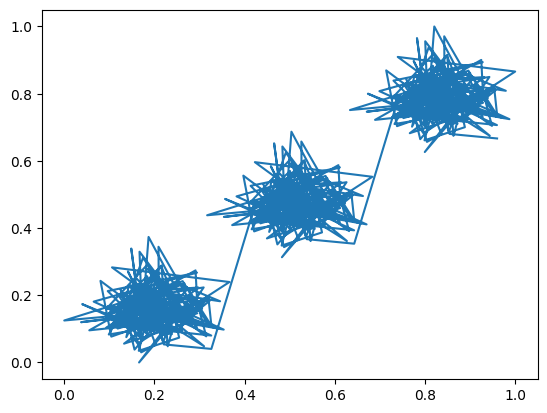

In [6]:
X_1=(X[0,:]-jnp.min(X[0,:]))/(jnp.max(X[0,:])-jnp.min(X[0,:]))
X_2=(X[1,:]-jnp.min(X[1,:]))/(jnp.max(X[1,:])-jnp.min(X[1,:]))
X_Normalized= np.vstack([X_1, X_2])
plt.plot(X_Normalized[0,:],X_Normalized[1,:])
X_Normalized[:10]

In [ ]:
#Vamos a correr con el modelo clásico:
model = Logistic_Regression()

In [ ]:
model.fit(X, Y,alpha=1e-2)

-676.342529296875
-7.675016403198242
-7.383470058441162
-7.13415002822876
-6.9269843101501465
-6.749616622924805
-6.593408107757568
-6.462484359741211
-6.34357213973999
-6.2360334396362305
-6.135219573974609
-6.04167366027832
-5.9582319259643555
-5.8834967613220215
-5.813196182250977
-5.746143817901611
-5.680942058563232
-5.619060516357422
-5.559511184692383
-5.5014142990112305
-5.444899559020996
-5.391321659088135
-5.3399810791015625
-5.2898430824279785
-5.243120193481445
-5.198091506958008
-5.155368804931641
-5.114501476287842
-5.075035095214844
-5.036285877227783
-4.998775005340576
-4.962931156158447
-4.927675724029541
-4.892994403839111
-4.858874797821045
-4.825296401977539
-4.792852878570557
-4.76129674911499
-4.730490684509277


In [ ]:
Y_hat = model.estimate(X_val)

In [ ]:
model.precision(Y_val, Y_hat)

1.0

In [ ]:
X_prob = model.estimate_prob(X)

Ejercico 1 a) y c). Implementar la función de coste regularizada buscando el parámetro lambda en un grid

-676.342529296875
-7.675016403198242
-7.383470058441162
-7.13415002822876
-6.9269843101501465
-6.749616622924805
-6.593408107757568
-6.462484359741211
-6.34357213973999
-6.2360334396362305
-6.135219573974609
-6.04167366027832
-5.9582319259643555
-5.8834967613220215
-5.813196182250977
-5.746143817901611
-5.680942058563232
-5.619060516357422
-5.559511184692383
-5.5014142990112305
-5.444899559020996
-5.391321659088135
-5.3399810791015625
-5.2898430824279785
-5.243120193481445
-5.198091506958008
-5.155368804931641
-5.114501476287842
-5.075035095214844
-5.036285877227783
-4.998775005340576
-4.962931156158447
-4.927675724029541
-4.892994403839111
-4.858874797821045
-4.825296401977539
-4.792852878570557
-4.76129674911499
-4.730490684509277
-676.342529296875
-7.675016403198242
-7.383470058441162
-7.13415002822876
-6.9269843101501465
-6.749616622924805
-6.593408107757568
-6.462484359741211
-6.34357213973999
-6.2360334396362305
-6.135219573974609
-6.04167366027832
-5.9582319259643555
-5.88349676

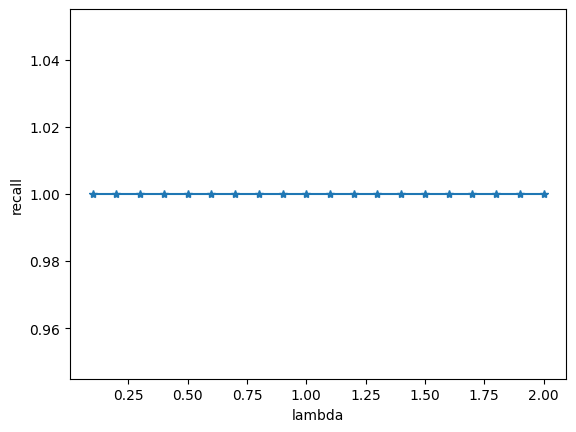

In [ ]:
max_step=int(20)
lbda=0
precision=np.zeros(int(max_step))
l_vec=np.zeros(int(max_step))
for i in range(max_step):
    lbda=lbda+0.1
    l_vec[i]=lbda
    model.fit(X, Y,lbda)
    Y_hat = model.estimate(X_val)
    precision[i]=model.precision(Y_val, Y_hat)

plt.plot(l_vec,precision,'*-')
plt.xlabel('lambda')
plt.ylabel('recall')
plt.show()

    

Ejercicio 1b). Broyden-Fletcher-Goldfarb-Shanno algorithm

array([[0.10002163, 0.198938  , 0.16338189, ..., 0.83017623, 0.8545037 ,
        0.95985866],
       [0.1281471 , 0.09202769, 0.21556805, ..., 0.78098893, 0.6802107 ,
        0.666713  ]], dtype=float32)

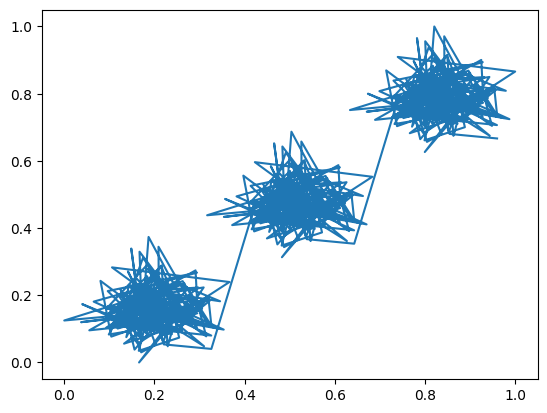

In [7]:
X, Y = tools.GenerateData(n_samples=200, n_classes=3, dim=2)
X_val, Y_val = tools.GenerateData(n_samples=50, n_classes=3, dim=2)
X_1=(X[0,:]-jnp.min(X[0,:]))/(jnp.max(X[0,:])-jnp.min(X[0,:]))
X_2=(X[1,:]-jnp.min(X[1,:]))/(jnp.max(X[1,:])-jnp.min(X[1,:]))
X_Normalized= np.vstack([X_1, X_2])
plt.plot(X_Normalized[0,:],X_Normalized[1,:])
X_Normalized[:10]


In [8]:
model_BFGS = Logistic_Regression(method_opt='BFGS')
model_BFGS.fit(X_Normalized, Y,alpha=0)
Y_hat = model.estimate(X_val)

    


antes de entrar, el w es:W [[0.7834176  0.37878197 0.        ]
 [1.         0.37196574 0.33544123]]
el error 0 es -788.4995
vamos en el paso 0
el error es -788.4995
el vector p es [-8.077566  -7.786477   6.3516717 -5.8890667 -5.239845   3.6114962]
este es 0
el alpha wolfe es []


ValueError: attempt to get argmin of an empty sequence

In [10]:
#imprimimos el recall
model_BFGS.precision(Y_val, Y_hat)


NameError: name 'Y_hat' is not defined

Ejercicio 2. Ahora vamos a implementar nuestros modelos para el set de datos de la tarea pasada. Se utilizará el archivo que ya se limpió en la tarea pasada.

In [25]:
import pandas as pd

In [26]:
data = pd.read_csv ('final.csv')   
df = pd.DataFrame(data)
X=df[df.columns[2:]].to_numpy()
y=df[df.columns[1]].to_numpy()
y=y.astype(int)
y=y[:500]
X=X[:500]
for i in range(len(y)):
    if y[i]==-1:
        y[i]=0

print(dim)
X=jax.numpy.asarray(X)
y=jax.numpy.asarray(y)

X=jnp.transpose(X)


104


In [27]:
model = Logistic_Regression()
model.fit(X, y,alpha=1e-2)

nan
nan
nan
nan
nan
nan


KeyboardInterrupt: 

In [ ]:
Y_hat = model.estimate(X_val)
model.precision(Y_val, Y_hat)